# Medford Disaster Router
<br>
<b>Contributors: Michael Ruggiero, Cengiz Imga, Dali Souayah

# Index

1. [Problem Statement](#PS)
2. [Data Preparation](#Data)
    1. [Major Road Functions](#MRF)
    2. [Routing](#Route)
    3. [Disaster Radius](#Dis)
    4. [Edge Manipulation and Visualizations](#EM)
3. [Dataset Creation](#Maker)
    1. [Data Cleaning](#Clean)
    2. [Statistics](#Stats)

In [1]:
#Import Libraries

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import webcolors
ox.config(use_cache=True, log_console=True)
ox.__version__

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. Problem Statement <a id = "PS"></a>

1) Build a NLP model that identifies peaks in twitter (or other social media) that would hint to road closures or disasters locations with Google maps

2) translate those identified locations into flags in a map

3) reflect the affected roads into a map in red color

4) produce a map of valid rescue roads/escape routes

## 2. Data Collection/Import Medford <a id = "Data"></a>

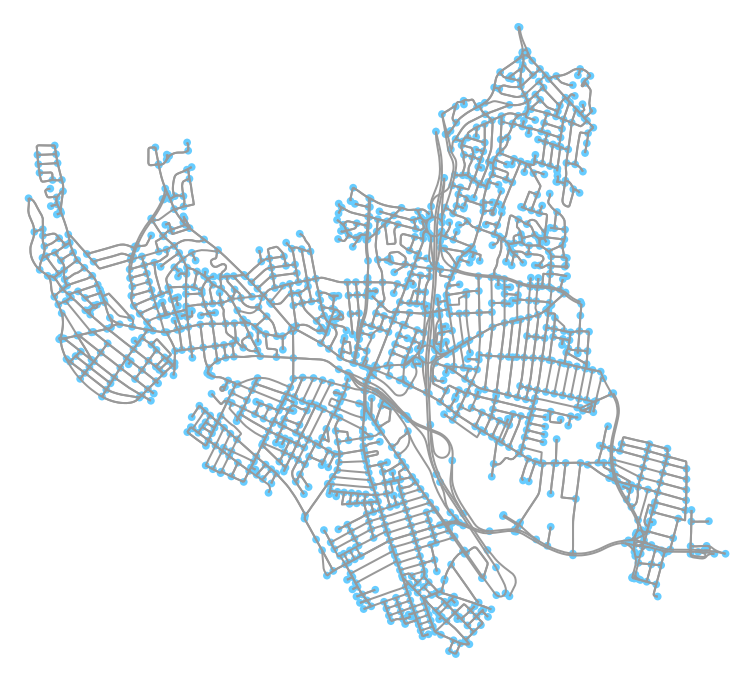

In [3]:
# get a graph for some city
place = {'city' : 'Medford',
         'state' : 'MA',
         'country' : 'USA'}
medford = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(medford)

In [4]:
# what sized area does our network cover in square meters?
medford_proj = ox.project_graph(medford)
nodes_proj = ox.graph_to_gdfs(medford_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

21010917.099306576

In [5]:
# show basic stats about the network
medford_stats = ox.basic_stats(medford_proj, 
                               area=graph_area_m, 
                               clean_intersects=True,
                               circuity_dist='euclidean')

# medford_stats = ox.extended_stats(medford_proj, ecc=True, bc=True, cc=True)

pd.DataFrame(medford_stats).set_index("streets_per_node_counts")

n     m     k_avg  intersection_count  \
streets_per_node_counts                                             
0                        1569  3862  4.922881                1361   
208                      1569  3862  4.922881                1361   
4                        1569  3862  4.922881                1361   
1094                     1569  3862  4.922881                1361   
254                      1569  3862  4.922881                1361   
9                        1569  3862  4.922881                1361   

                         streets_per_node_avg  streets_per_node_proportion  \
streets_per_node_counts                                                      
0                                    2.905672                     0.000000   
208                                  2.905672                     0.132569   
4                                    2.905672                     0.002549   
1094                                 2.905672                     0.697259   
254                                  2.905672                     0.161887   
9                                    2.905672                     0.005736   

                         edge_length_total  edge_length_avg  \
streets_per_node_counts                                       
0                               397167.386        102.83982   
208                             397167.386        102.83982   
4                               397167.386        102.83982   
1094                            397167.386        102.83982   
254                             397167.386        102.83982   
9                               397167.386        102.83982   

                         street_length_total  street_length_avg  \
streets_per_node_counts                                           
0                                 239165.907         106.485266   
208                               239165.907         106.485266   
4                                 239165.907         106.485266   
1094                              239165.907         106.485266   
254                               239165.907         106.485266   
9                                 239165.907         106.485266   

                         street_segments_count  node_density_km  \
streets_per_node_counts                                           
0                                         2246        74.675465   
208                                       2246        74.675465   
4                                         2246        74.675465   
1094                                      2246        74.675465   
254                                       2246        74.675465   
9                                         2246        74.675465   

                         intersection_density_km  edge_density_km  \
streets_per_node_counts                                             
0                                      64.775849     18902.905767   
208                                    64.775849     18902.905767   
4                                      64.775849     18902.905767   
1094                                   64.775849     18902.905767   
254                                    64.775849     18902.905767   
9                                      64.775849     18902.905767   

                         street_density_km  circuity_avg  \
streets_per_node_counts                                    
0                              11382.93516        1.0391   
208                            11382.93516        1.0391   
4                              11382.93516        1.0391   
1094                           11382.93516        1.0391   
254                            11382.93516        1.0391   
9                              11382.93516        1.0391   

                         self_loop_proportion  clean_intersection_count  \
streets_per_node_counts                                                   
0                                    0.002071                      1115   
208         

##### Edge and Node Dataframe

In [6]:
# Edge and Node projection
nodes_med, edges_med = ox.graph_to_gdfs(medford, nodes=True, edges=True)

In [7]:
nodes_med.head(2)

highway       osmid  ref          x          y  \
66478081     turning_circle    66478081  NaN -71.100780  42.429287   
1095962629  traffic_signals  1095962629  NaN -71.110312  42.415123   

                                  geometry  
66478081    POINT (-71.1007798 42.4292871)  
1095962629  POINT (-71.1103119 42.4151234)

In [8]:
#Number of intersections
nodes_med.shape

(1569, 6)

## 2a. Major Roads Functions<a id = "MRF"></a>

In [9]:
def colorer(color):
    answer = []
    for i in color:
        answer.append(int(255 *i))
    
    return answer

def closest_color(color):
    min_colors = {}
    for key, name in webcolors.css3_hex_to_names.items():
        red, green, blue = webcolors.hex_to_rgb(key)
        rd = (red - color[0]) ** 2
        gd = (green - color[1]) ** 2
        bd = (blue - color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

def random_color_matrix(dictionary):
    """generates a random RBG dictionary from three linspaces"""
    
    keys = list(dictionary.keys()) 
    size = len(keys)
    
    #These are three three random linspaces
    A = np.linspace(.2,.8, size)
    np.random.shuffle(A)

    B = np.linspace(.2,.8, size)
    np.random.shuffle(B)

    C = np.linspace(.2,.8, size)
    np.random.shuffle(C)
    
    color_dictionary = {"minor" : 'whitesmoke'}

    for i in range(len(keys)):
        color_dictionary[keys[i]] = closest_color(colorer((A[i],
                                                           B[i],
                                                           C[i])))
    color_dictionary["minor"] = 'whitesmoke'
    
    return color_dictionary

def node_labeler(node, color_dictionary, dictionary, paint_mode = 0):
    """
    labeles nodes based on dictionary entries
    
    paint_mode = 0, produces a name
    otherwise, produces color
    
    """
    answer = []
    for key in dictionary:
        if node in dictionary[key]:
            answer.append(key)

    if paint_mode == 0:
        if len(answer) == 0 or answer[0] == "minor":
            return "minor"
        elif len(answer) == 1:
            return answer[0]
        else: return " ".join(answer)
    
    else:
        if len(answer) == 0:
            return color_dictionary["minor"] 
        elif len(answer) == 1:
            return color_dictionary[answer[0]]
        else:
            return "black"
            
def node_roader(edges_df,nodes_df):
    """
    edges_df is the edge projection, nodes_df is the node projection
    
    a
    """
    major_roads = set(edges_df[edges_df.ref.notna()].ref.values)
    major_roads = dict.fromkeys(major_roads, set())
    color_dict = random_color_matrix(major_roads)
    
    
    #Return printout to terminal and build major_road dict
    for road in major_roads:
        print("{:<5} \t nodes in {:>5} \t colored \t {}".format(len(edges_df[edges_df.ref == road]),
                                                 road,
                                                 color_dict[road]))
              
        major_roads[road] = set(edges_df[edges_df.ref == road].u) | \
                            set(edges_df[edges_df.ref == road].v)
    
    
    #Make Colored Columns for edges
    edges_df.ref.fillna("minor", inplace = True) # Remove all NaN 
    edges_df["color"] = edges_df.ref.apply(lambda a: color_dict[a])
    
    #Make Colored columns for nodes
    nodes_df["major"] = nodes_df.osmid.apply(lambda a: node_labeler(a,
                                                                    color_dict,
                                                                    major_roads,0))
    nodes_df["color"] = nodes_df.osmid.apply(lambda a: node_labeler(a,
                                                                    color_dict,
                                                                    major_roads,1))
    
    nodes_df["major_inter"] = nodes_df.major.apply(lambda a: a.count(" "))
    
    #generate graph
    graph = ox.gdfs_to_graph(nodes_df, edges_df)
    
    
    #Build coloring lines
    edge_color = [edges_df[(edges_df.u == i[0]) & (edges_df.v == i[1])].color.values[0] for i in graph.edges()]
    node_color = [nodes_df.loc[i].color for i in graph.nodes()]
    
    ox.plot_graph(graph,
                  node_size=10,
                  node_color = node_color, 
                  edge_color = edge_color,
                  annotate=False,
                  dpi = 600,
                  edge_alpha = .5
                );
    
    data_dictionary = {"graph":graph,
                       "edges":edges_df,
                       "nodes":nodes_df,
                       "major_roads":major_roads,
                       "color_dictionary":color_dict,
                       "edge_color":edge_color,
                       "node_color":node_color}
    
    return data_dictionary

12    	 nodes in  I 93 	 colored 	 slateblue
143   	 nodes in MA 60 	 colored 	 brown
4     	 nodes in MA 16;MA 38 	 colored 	 yellowgreen
76    	 nodes in MA 28 	 colored 	 silver
51    	 nodes in MA 16 	 colored 	 seagreen
96    	 nodes in MA 38 	 colored 	 rosybrown
5     	 nodes in MA 38;MA 60 	 colored 	 darkslateblue


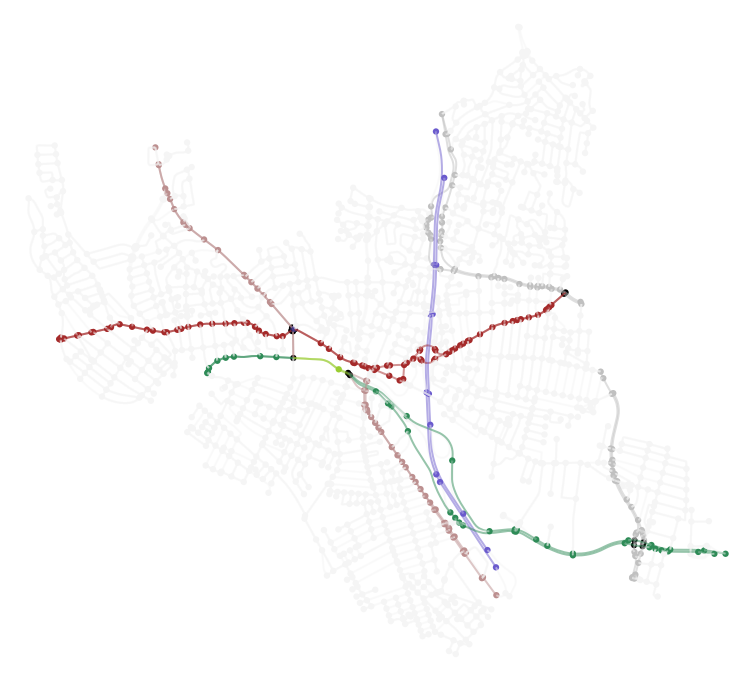

In [10]:
medford_data = node_roader(edges_med,nodes_med)

In [11]:
edges_med, nodes_med = medford_data["edges"], medford_data["nodes"]

In [12]:
edges_med.ref.value_counts()

minor          3475
MA 60           143
MA 38            96
MA 28            76
MA 16            51
I 93             12
MA 38;MA 60       5
MA 16;MA 38       4
Name: ref, dtype: int64

In [13]:
nodes_med.major.apply(lambda a: a.count(" ")).value_counts()

0    1286
1     268
3       6
4       4
6       3
2       2
Name: major, dtype: int64

In [14]:
#Long Lat information 
nodes_med[["x","y"]].describe()

x            y
count  1569.000000  1569.000000
mean    -71.107867    42.419430
std       0.015947     0.010365
min     -71.145410    42.396426
25%     -71.118687    42.411989
50%     -71.105661    42.420096
75%     -71.095526    42.426626
max     -71.073105    42.444456

In [15]:
#Random Node Sampler
nodes_med[["x","y"]].sample(1).values

array([[-71.1454097,  42.4313311]])

## 2b. Routing<a id = "Route"></a>

In [19]:
#Random Point Generator
def random_point(lower = -180, higher = 180):
    return (np.random.uniform(low=lower, high=higher),
            np.random.uniform(low=lower, high=higher))

print(random_point())

(-93.22391690810609, 71.01662881753293)


In [20]:
random_point_A = random_point()
random_point_B = random_point()

# get the nearest network node to each random point
orig_node = ox.get_nearest_node(medford, random_point_A)
dest_node = ox.get_nearest_node(medford, random_point_B)

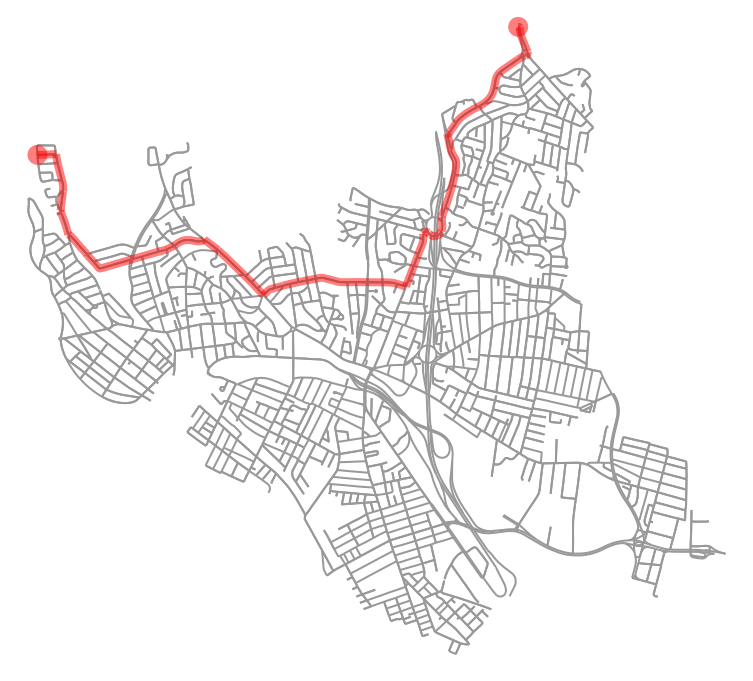

In [445]:
# find the route between these nodes then plot it
route = nx.shortest_path(medford, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(medford, route, node_size=0)

In [22]:
# Length of route in meters
nx.shortest_path_length(medford, orig_node, dest_node, weight='length')

6934.464000000004

In [23]:
# Absolute Distance between two nodes (as the crow flies)
ox.great_circle_vec(medford.node[orig_node]['y'], medford.node[orig_node]['x'],
                    medford.node[dest_node]['y'], medford.node[dest_node]['x'])

4234.973441984093

## 2c. Disaster Radius<a id = "Dis"></a>

In [24]:
nodes_med[["y","x"]].sample(1).values[0]

array([ 42.4171935, -71.099473 ])

In [25]:
def disaster_generator(location_point = 0, distance = 0):
    # define a point at the corner of a box
    if location_point == 0:
        location_point = nodes_med[["y","x"]].sample(1).values[0]

    if distance == 0:
        distance=2000*np.random.uniform()
    # create network from point, inside bounding box of N, S, E, W each 1750m from point
    disaster = ox.graph_from_point(location_point,
                             distance=distance,
                             distance_type='network',
                             network_type='drive')
    fig, ax = ox.plot_graph(disaster, node_size=30, node_color='red')
    
    return disaster

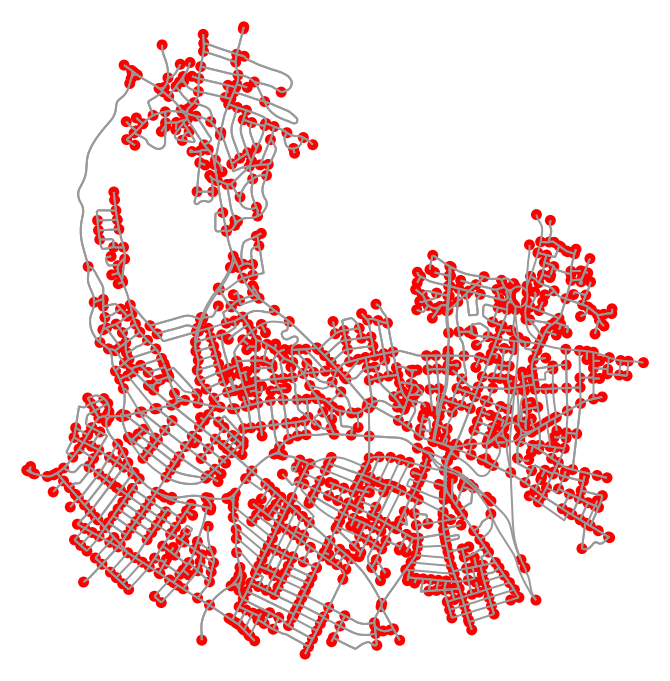

In [26]:
disaster = disaster_generator(0,3000)

In [27]:
nodes_dis, edges_dis = ox.graph_to_gdfs(disaster)

In [28]:
edges_dis.head(2)

access bridge                                           geometry  \
0    NaN    NaN  LINESTRING (-71.1007798 42.4292871, -71.100584...   
1    NaN    NaN  LINESTRING (-71.1382188 42.4132064, -71.137819...   

       highway junction  key lanes  length maxspeed            name  oneway  \
0  residential      NaN    0     2  86.903      NaN     Leon Circle   False   
1  residential      NaN    0     2  58.344      NaN  Everett Street   False   

     osmid  ref           u         v width  
0  9038637  NaN    66478081  66479406  10.1  
1  8654029  NaN  1808347139  61692374  11.9

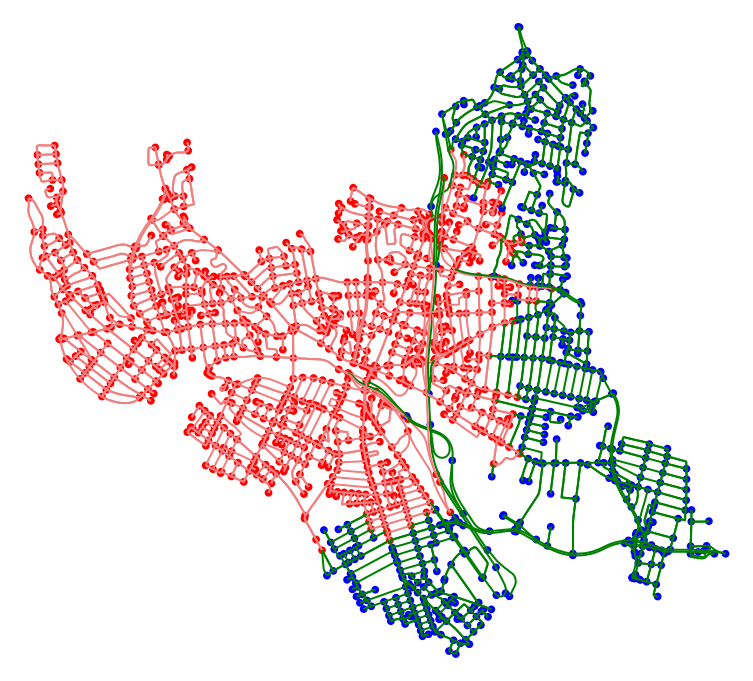

(<Figure size 650.491x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12233bcf8>)

In [29]:
#Set Colors
ec = ['lightcoral' if i in disaster.edges() else 'green' for i in medford.edges()]
nc = ['red' if i in disaster.nodes() else 'blue' for i in medford.nodes()]

#Plot energency grid
ox.plot_graph(medford, node_size=15, node_color = nc ,edge_color=ec)


In [30]:
live = []

for i in medford.edges():
    if i not in disaster.edges():
        live.append(i[0])

In [31]:
live = edges_med[edges_med["u"].isin(live)]

In [32]:
live.size

25602

In [33]:
edges_med.size

65654

In [34]:
med_live = ox.gdfs_to_graph(nodes_med, live)

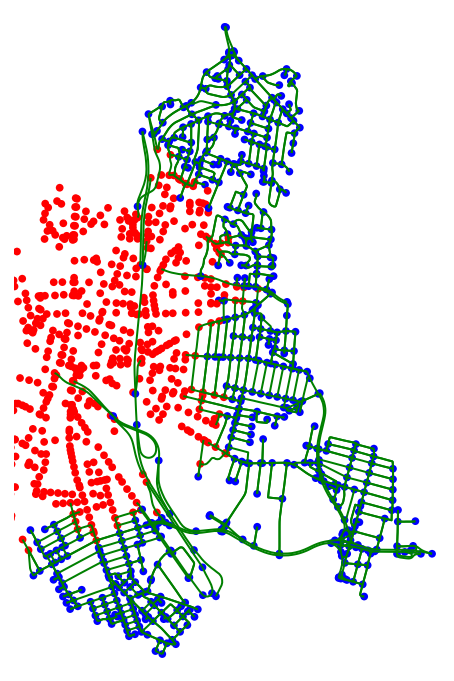

In [35]:
ox.plot_graph(med_live, node_size=15, node_color = nc ,edge_color="g");

## 2d. Edge Manipulation and Visualizations<a id = "EM"></a>

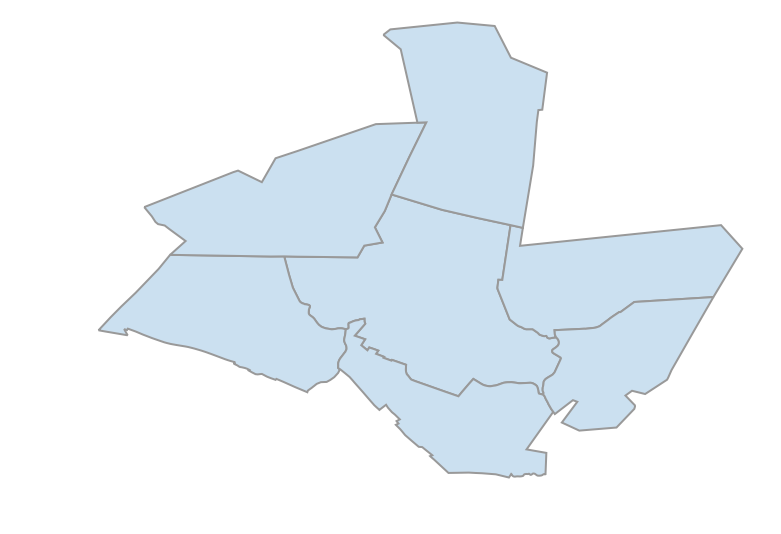

In [36]:
# get the boundary polygons for neighboring cities, save as shapefile, project to UTM, and plot
place_names = ['Medford, MA, USA', 
               'Arlington, MA, USA',
               'Somerville, MA, USA',
               'Malden, MA, USA',
#                'Melrose, MA, USA',
               'Winchester, MA, USA',
               'Stoneham, MA, USA',
               'Everett, MA, USA',
              ]
medford_area = ox.gdf_from_places(place_names)
fig, ax = ox.plot_shape(medford_area)

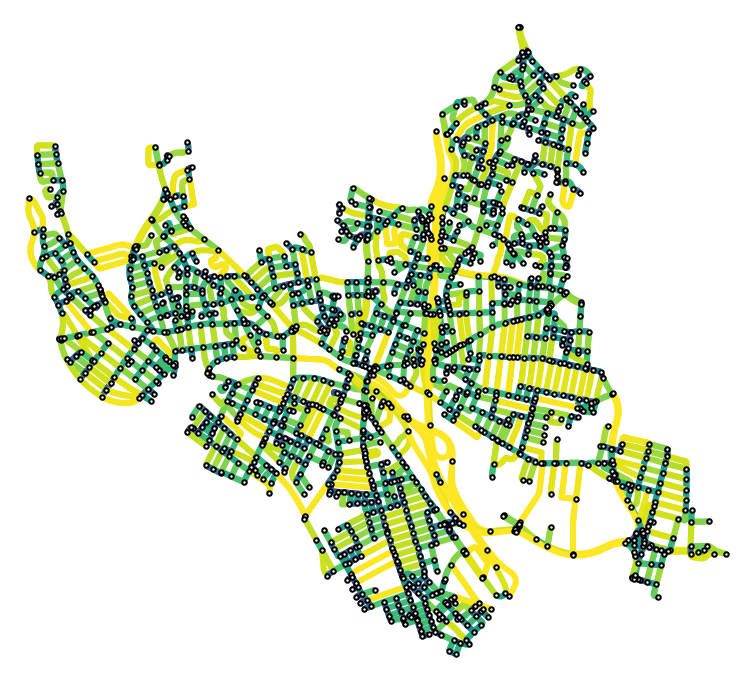

In [37]:
# Roads colored by edge length
ec = ox.get_edge_colors_by_attr(medford, attr='length', num_bins=200)
fig, ax = ox.plot_graph(medford, node_color='w', node_edgecolor='k', node_size=5, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

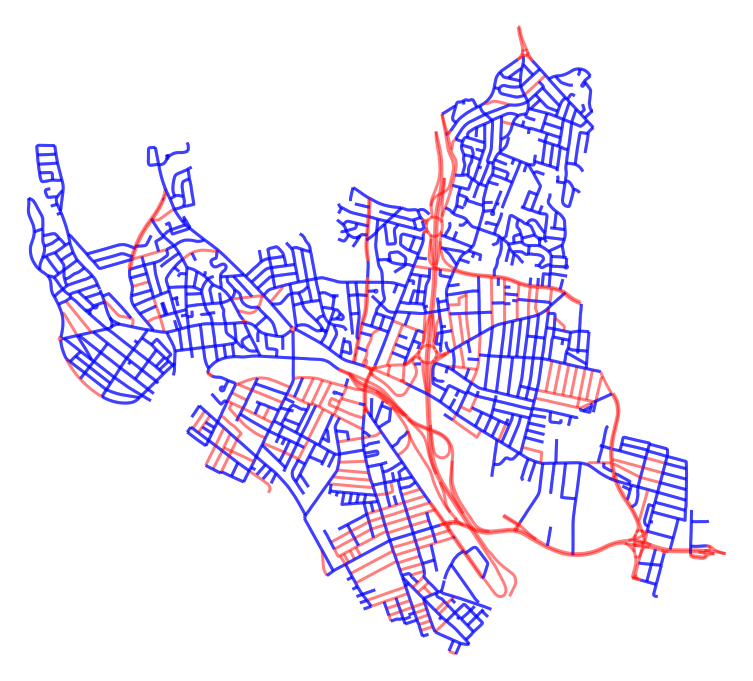

In [38]:
# highlight one-way roads
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in medford.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(medford, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

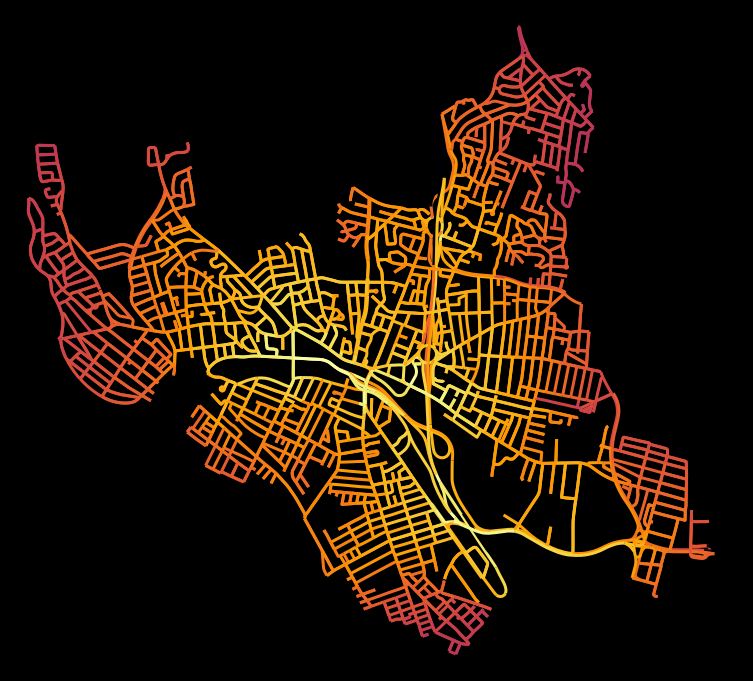

In [39]:
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(medford))

# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in medford.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(medford, bgcolor='k', axis_off=True, node_size=0,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

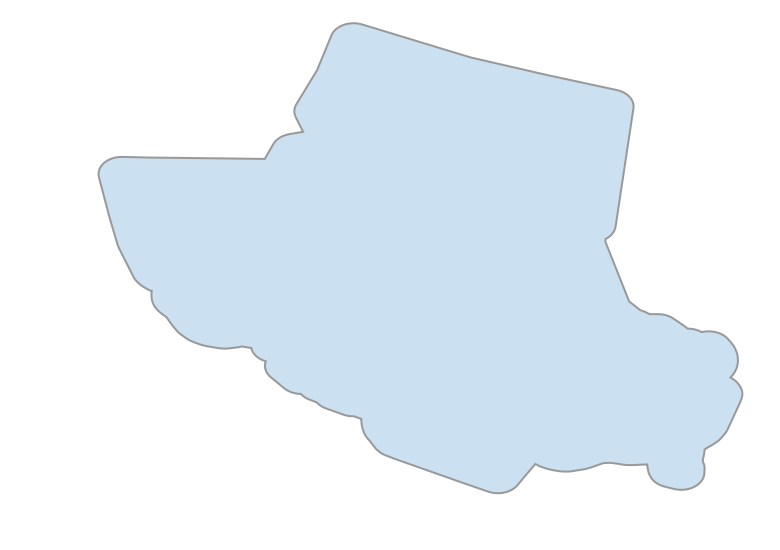

In [40]:
# Buffer radius around Medford
medford_buffered = ox.gdf_from_place(place, buffer_dist=250)
fig, ax = ox.plot_shape(medford_buffered)

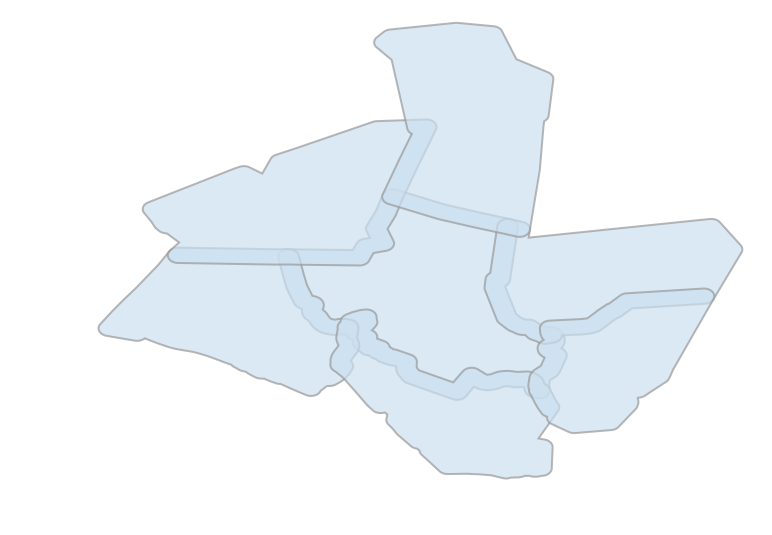

In [41]:
#Neighboor hoods buffered
neigboors_buffered = ox.gdf_from_places(place_names, gdf_name='neighboors', buffer_dist=250)
fig, ax = ox.plot_shape(neigboors_buffered, alpha=0.7)

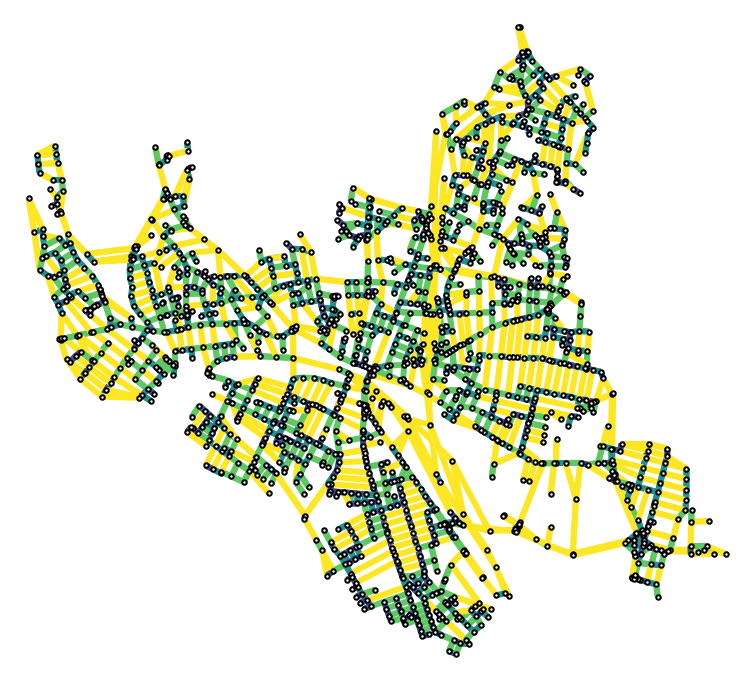

In [42]:
# plot same network again (topologically isomorphic), this time ignoring the edges' spatial geometry
ec = ox.get_edge_colors_by_attr(medford, attr='length')
fig, ax = ox.plot_graph(medford, node_color='w', node_edgecolor='k', node_size=5, node_zorder=3, 
                           edge_color=ec, edge_linewidth=3, edge_alpha=1, use_geom=False)

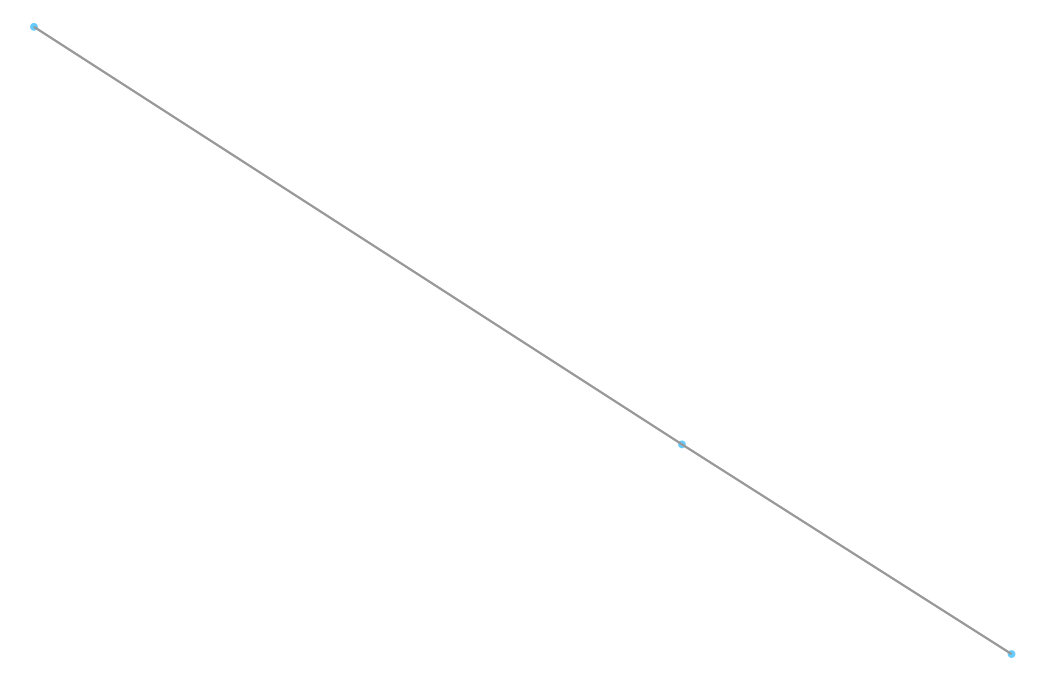

In [43]:
neighbor = ox.graph_from_address(address='18 Pembroke St,\
                                    Medford, MA 02155',
                                 distance=100,
                                 distance_type='network',
                                 network_type='drive')

neighbor_projected = ox.project_graph(neighbor)
fig, ax = ox.plot_graph(neighbor_projected)

## 3. Data Creation <a id = "Maker"></a>

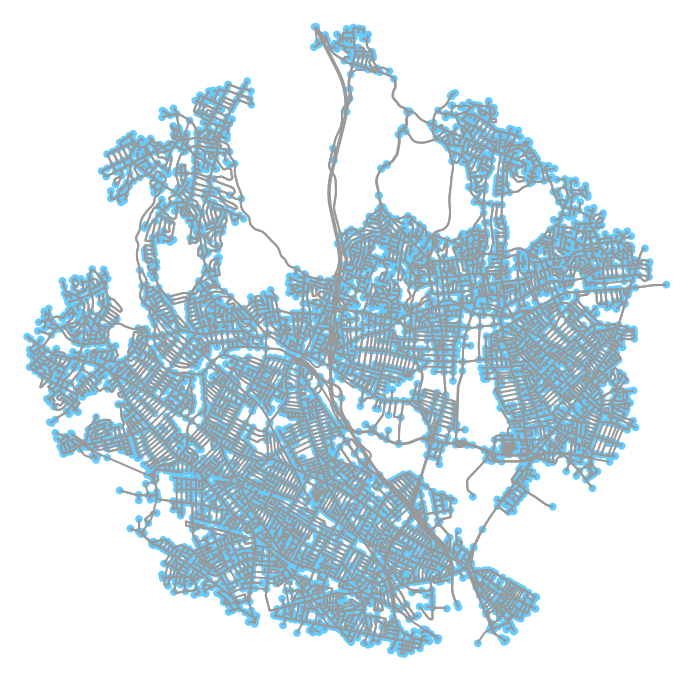

In [44]:
# network from address, including only nodes within 6.5km along the network from city hall
neighbor = ox.graph_from_address(address='85 George P. Hassett Drive,\
                                    Medford, MA 02155',
                                    distance=6500, distance_type='network', network_type='drive')

# you can project the network to UTM (zone calculated automatically)
neighbor_projected = ox.project_graph(neighbor)
fig, ax = ox.plot_graph(neighbor_projected)

In [45]:
# Edge and Node projection
nodes_area, edges_area = ox.graph_to_gdfs(neighbor_projected,
                                        nodes=True,
                                        edges=True)

In [46]:
print(nodes_med.shape)
print(nodes_area.shape)

(1569, 9)
(7502, 8)


In [47]:
nc = ['blue' if i in medford.nodes() else 'green' for i in neighbor.nodes()]


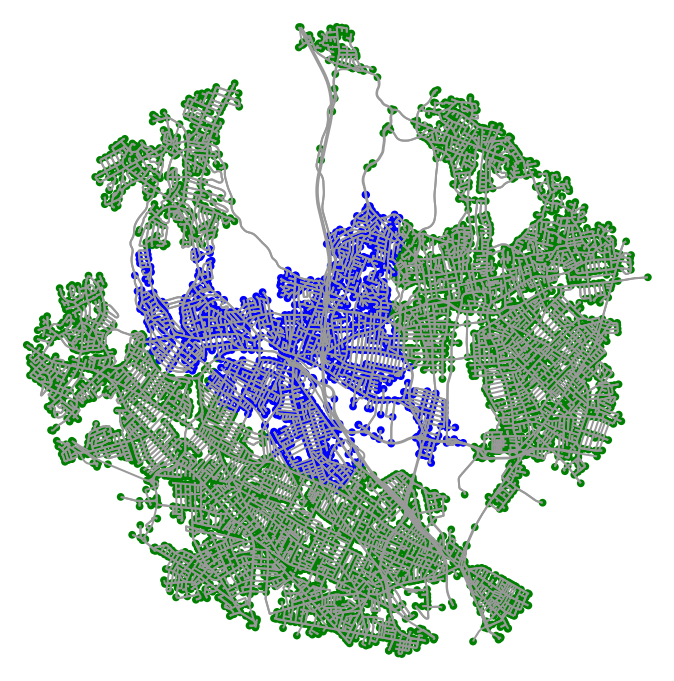

In [48]:
ox.plot_graph(neighbor,
              node_size=15,
              node_color = nc);


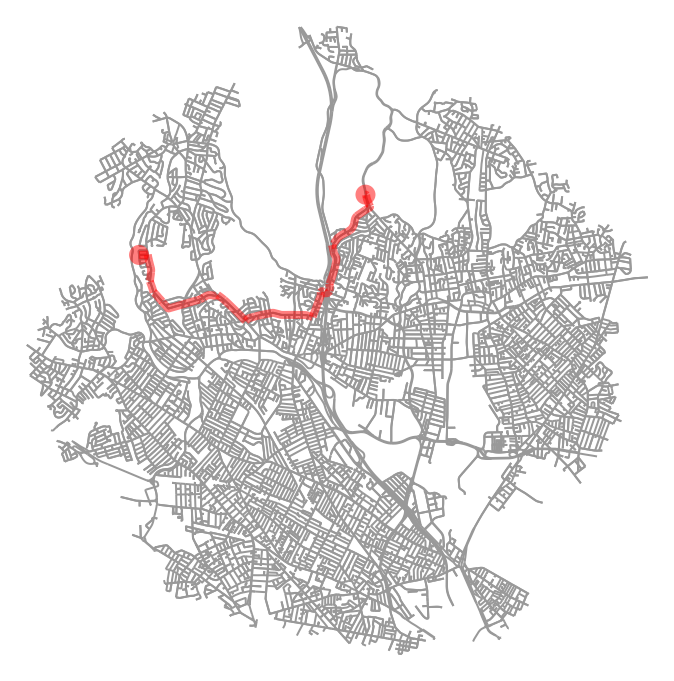

In [49]:
# find the route between these nodes then plot it
route = nx.shortest_path(neighbor, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(neighbor, route, node_size=0)

165   	 nodes in MA 28 	 colored 	 indianred
42    	 nodes in  US 3 	 colored 	 darkseagreen
161   	 nodes in MA 99 	 colored 	 steelblue
120   	 nodes in MA 16 	 colored 	 dimgrey
182   	 nodes in MA 38 	 colored 	 limegreen
13    	 nodes in US 3;MA 16 	 colored 	 darkseagreen
319   	 nodes in MA 60 	 colored 	 rosybrown
5     	 nodes in MA 38;MA 60 	 colored 	 mediumaquamarine
24    	 nodes in  I 93 	 colored 	 olivedrab
8     	 nodes in  MA 2 	 colored 	 sienna
4     	 nodes in MA 16;MA 38 	 colored 	 mediumorchid
140   	 nodes in MA 2A 	 colored 	 cadetblue
5     	 nodes in US 3;MA 2A;MA 60 	 colored 	 darkorchid
105   	 nodes in US 3;MA 2A 	 colored 	 firebrick
26    	 nodes in US 3;MA 2;MA 16 	 colored 	 darkslategrey


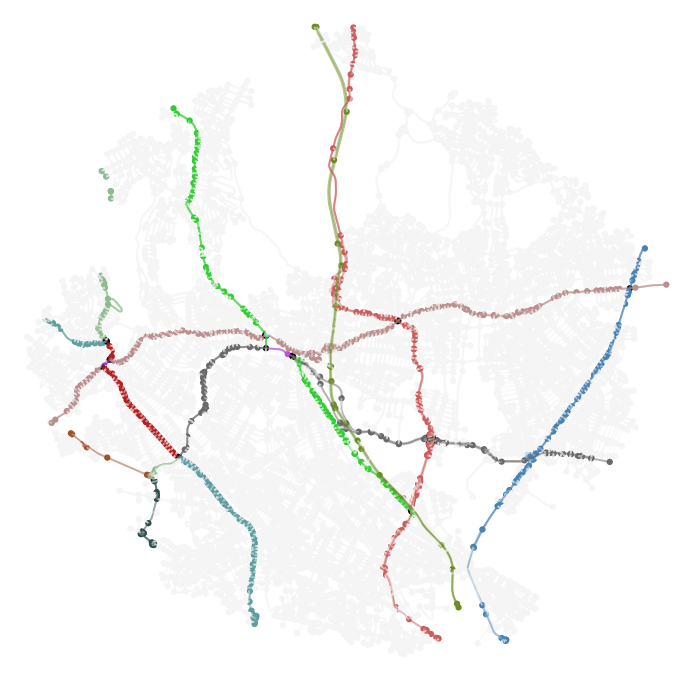

In [50]:
neighbor_data = node_roader(edges_area,nodes_area)

##### Make Random route CSV for google

In [263]:
nodes_med[["x","y"]].describe()

x            y
count  1569.000000  1569.000000
mean    -71.107867    42.419430
std       0.015947     0.010365
min     -71.145410    42.396426
25%     -71.118687    42.411989
50%     -71.105661    42.420096
75%     -71.095526    42.426626
max     -71.073105    42.444456

In [271]:
nodes_med.x.quantile(q = .25)

-71.1186871

In [441]:
def zone_picker(df, times = 1, start = -1, end = -1):
    """from a list of random zones, returns start and end"""
    
    #Build data dictionary for each zone
    zone = {} 
    zone[0] = df[(df.x < df.x.quantile(q = .25)) & 
                        (df.y < df.y.quantile(q = .25))].copy()

    zone[1] =df[(df.x > df.x.quantile(q = .75)) & 
                       (df.y > df.y.quantile(q = .75))].copy()

    zone[2] = df[(df.x > df.x.quantile(q = .75)) & 
                        (df.y < df.y.quantile(q = .25))].copy()

    zone[3] = df[(df.x < df.x.quantile(q = .25)) & 
                        (df.y > df.y.quantile(q = .75))].copy()

    #Build choice list
    choices = np.random.choice(range(3),2,replace=False)
    choices = {"start":choices[0], "end":choices[1]}
    
    #Test for valid Start/End options
    if start in range(3):
        choices["start"] = start
        
    if end in range(3) and end != start and start != -1:
        choices["end"] = end

    #Build answer dic    
    start_dic = zone[choices["start"]].sample(1)[["osmid","x","y"]].to_dict()
    start_dic = pd.DataFrame({k+'_start': v for k, v in start_dic.items()})
    start_dic["start_zone"] = choices["start"]
    
    #Build temporary end dic
    end_dic = zone[choices["end"]].sample(1)[["osmid","x","y"]].to_dict()
    end_dic = pd.DataFrame({k+'_end': v for k, v in end_dic.items()})
    end_dic["end_zone"] = choices["end"]
    
    #rename index of end_dic dataframe
    end_dic.rename(index={end_dic.index[0]:start_dic.index[0]}, inplace=True)
    
    #join Dataframes
    start_dic = start_dic.join(end_dic).reset_index(drop=True)
    
    times = ["15:30", "17:30"]

    start_dic["Time"] = "8:30"
    for i in range(1,3): start_dic.loc[i] = start_dic.loc[0]
    for i in range(1,3): start_dic.loc[i,"Time"] = times[i - 1]
    
    answer = start_dic.copy()
    return answer

def random_zone_picker(df,times):
    main = zone_picker(df)
    for i in range(times - 1):
        iterate = zone_picker(df)
        main = pd.concat([main,iterate],
                         keys = ["x","y"]).reset_index(drop=True)
        
        if i % 250 == 0: print(i)
            
    return main

In [442]:
router = random_zone_picker(nodes_med, 4_000)

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750


In [444]:
router.to_csv("routes_with_zones.csv")

In [325]:
choices = np.random.choice(range(3),2,replace=False)
choices = {"start":choices[0], "end":choices[1]}

In [326]:
choices

{'start': 0, 'end': 2}

In [69]:
neighbor_data["nodes"].major.value_counts()

minor                                6584
MA 60                                 182
MA 28                                 150
MA 2A                                 123
MA 38                                 111
MA 99                                  91
MA 16                                  90
US 3;MA 2A                             54
I 93                                   25
US 3                                   23
US 3;MA 2;MA 16                        21
MA 2                                    8
US 3;MA 16                              7
MA 60 US 3;MA 2A;MA 60 US 3;MA 2A       4
MA 28 MA 16                             4
MA 16 MA 38 MA 16;MA 38                 3
US 3;MA 2A;MA 60                        3
MA 60 MA 38;MA 60                       2
MA 38 MA 38;MA 60                       2
MA 28 MA 60                             2
MA 28 MA 38                             2
MA 2A US 3;MA 2A                        1
MA 60 US 3;MA 2A                        1
MA 99 MA 60                       

In [70]:
nodes_neighbor, edges_neighbor = neighbor_data["nodes"], neighbor_data["edges"]

In [79]:
major_nodes_neighbor = nodes_neighbor[nodes_neighbor.major != "minor"].copy()
major_edges_neighbor = edges_neighbor[edges_neighbor.ref != "minor"].copy()

major_nodes_neighbor.reset_index(inplace = True)
major_edges_neighbor.reset_index(inplace = True)

minor_nodes_neighbor = nodes_neighbor[nodes_neighbor.major == "minor"]

kill = np.asarray(minor_nodes_neighbor.osmid.values)

a = ox.gdfs_to_graph(nodes_neighbor,
                     major_edges_neighbor)

ox.plot_graph(a);

In [240]:
ae, an = ox.graph_to_gdfs(a)

In [241]:
for i in kill:
    a.remove_node(i)

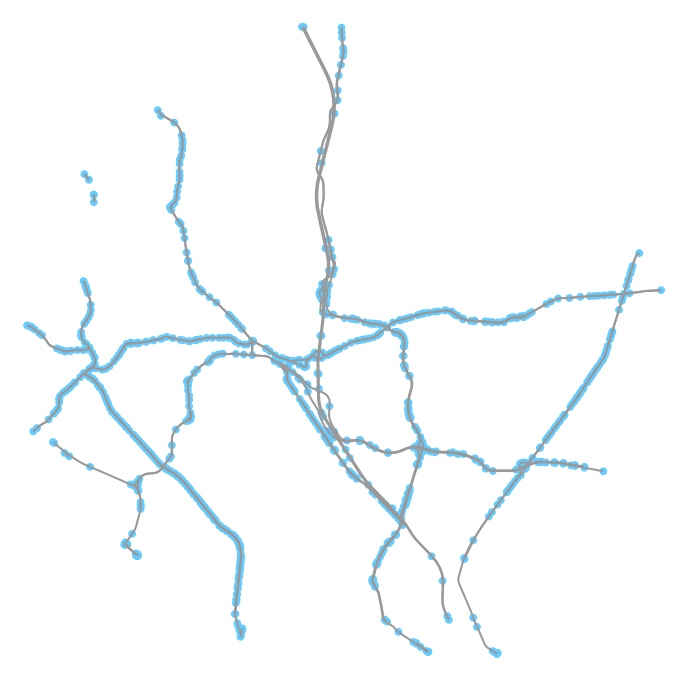

In [242]:
ox.plot_graph(a);

In [235]:
nx.degree_histogram(a)

[0, 22, 490, 10, 384, 4, 7, 0, 1]

color                                     geometry  \
67027002      dimgrey  POINT (329612.2240064438 4696626.039258881)   
67027031    steelblue  POINT (330213.0882128028 4696141.592966977)   
66453596    indianred   POINT (327136.3849736558 4699188.67337465)   
66486371    rosybrown   POINT (326693.2213593228 4698400.07083477)   
3804299390  limegreen  POINT (328035.5764281429 4695840.657972014)   

                    highway        lat        lon  major  major_inter  \
67027002                NaN  42.403244 -71.070468  MA 16            1   
67027031                NaN  42.399015 -71.063028  MA 99            1   
66453596    traffic_signals  42.425760 -71.101303  MA 28            1   
66486371    traffic_signals  42.418564 -71.106449  MA 60            1   
3804299390              NaN  42.395828 -71.089379  MA 38            1   

                 osmid  ref              x             y  
67027002      67027002  NaN  329612.224006  4.696626e+06  
67027031      67027031  NaN  330213.088213  4.696142e+06  
66453596      66453596  NaN  327136.384974  4.699189e+06  
66486371      66486371  NaN  326693.221359  4.698400e+06  
3804299390  3804299390  NaN  328035.576428  4.695841e+06

In [187]:
while nx.degree_histogram(a)[2] > 0:
    for i in a.nodes():
        if nx.degree(a,i) == 2:
            print(i)
            for j in nx.all_neighbors(a,i):
                a = nx.contracted_nodes(a, i, j, self_loops=True)

            break

61327504
3403188378
3403188379
3403188375
61327517
67029203
66423152
61327730
5175445905
71944639
66456019
66423297
3833661985
66439794
5690346177
67013448
61688666
66440128
634899414
634899420
66423838
66440289
61688938
67030214
3179777279


NetworkXError: nbunch is not a node or a sequence of nodes.

In [171]:
def node_collapse(graph):
    """collapses all of the nodes with degree = 2"""
    while nx.degree_histogram(graph)[2] > 0: 
        for i in graph.nodes():
            if nx.degree(graph,i) == 2:
                for j in nx.all_neighboors(a,i):
                    graph = nx.contracted_nodes(graph, i, j, self_loops=True)
    return graph

In [181]:
while nx.degree_histogram(a)[2] > 0:
    i = 0
    node = list(a.nodes())[i]
    if nx.degree(a,i) == 2:
        for j in nx.all_neighboors(a,node):
            a = nx.contracted_nodes(graph, node, j, self_loops=True)
    else: i += 1

NetworkXError: nbunch is not a node or a sequence of nodes.

In [176]:
list(a.nodes())[0]

67027002